In [1]:
from matplotlib import pyplot as plt
import numpy as np
from collections import defaultdict
from numpy.random import poisson as poi
import time
import genSIRUniverse as gsu
from mpl_toolkits.axes_grid1 import make_axes_locatable, ImageGrid
from mpl_toolkits.axes_grid1.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)

from numpy import poly1d, polyfit
import pandas as pd
import time
import seaborn as sns; sns.set(style="ticks", color_codes=True)

from sklearn.decomposition import NMF, PCA
from sklearn.manifold import LocallyLinearEmbedding, TSNE, Isomap, SpectralEmbedding, MDS
from pydiffmap import diffusion_map as dm

%matplotlib inline
%load_ext autoreload
%autoreload 2

Intel(R) Data Analytics Acceleration Library (Intel(R) DAAL) solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


In [2]:
#Some global definitions
state_loc = {"S":0, "I":1, "R":2}

-----
# You can ignore this notebook if you want.

In [7]:
universe_sh=(8,8)
conn = gsu.gen_von_neumann(*universe_sh, periodic=True)
su10 = gsu.sir_universe(universe_sh=universe_sh, conn=conn, alpha=0.01, beta=0.8, gamma=0.2, avg_pop_per_node=10000)
su10.initialize()
su10.iterate(1000, verbose=True)

1000 iterations took 0.289s


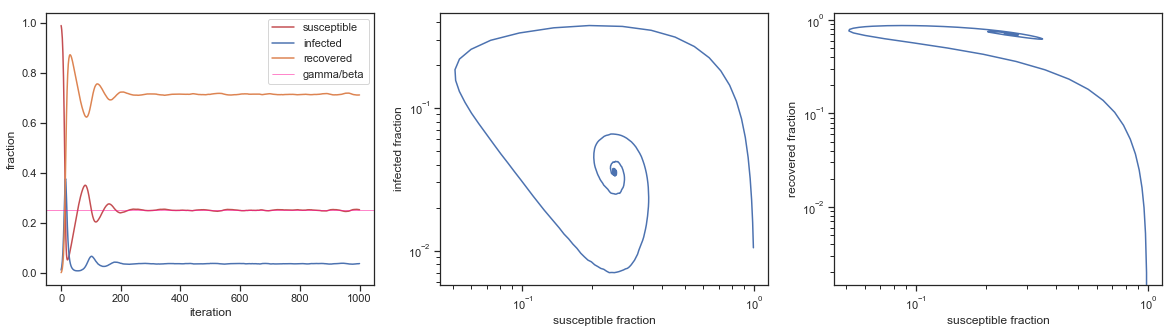

In [8]:
su10.show_state_vs_time()

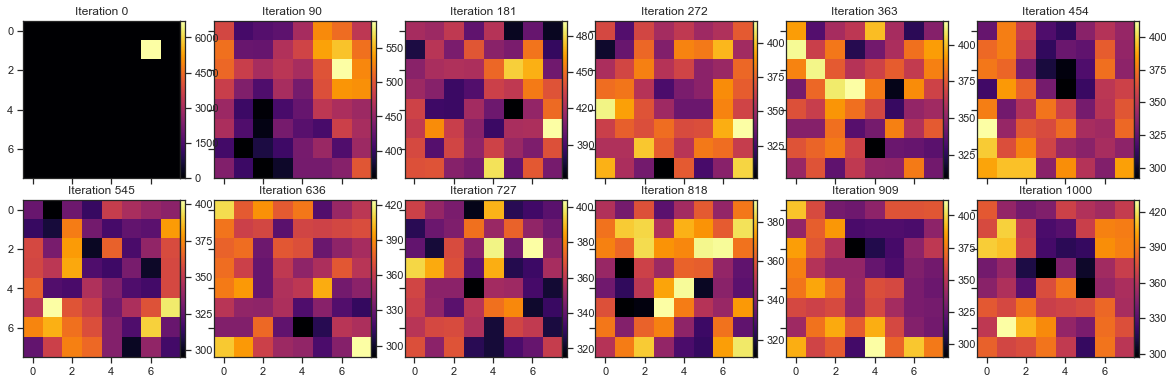

In [9]:
su10.show_snapshots(figsize=(20,10), nrows_ncols=(2,6))

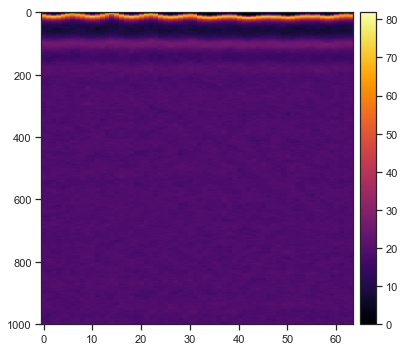

In [34]:
gsu.my_single_imshow(su10.np_state[:, su10.state_dict["I"],:]**0.5)

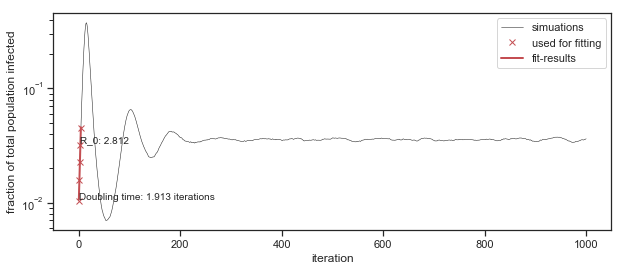

In [12]:
(doubling_time, r0) = su10.compute_r0(fit_t_range=[0,5])

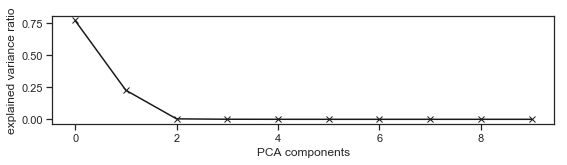

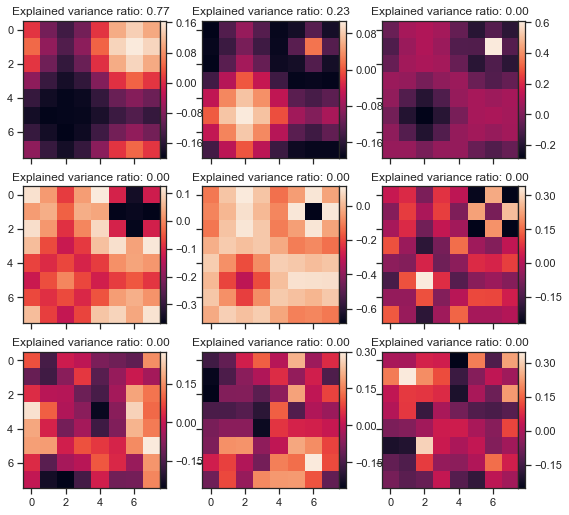

In [35]:
input_arr = su10.np_state[:400,state_loc["I"]].T
#pair_dot = np.matmul(input_arr.T, input_arr)
pair_dot = np.cov(input_arr)
#pair_dot = np.asarray([np.corrcoef(a, b)[1,0] for a in input_arr for b in input_arr]).reshape(len(input_arr), -1)
pca_model, pca_transformed_input = gsu.pca_and_view(pair_dot, num_components=10, plot=False)
gsu.view_pca_2(pca_model, universe_sh, show_shape=(3,3))


In [36]:
time_of_first_infection = [ii.argmax() for ii in input_arr]

/Users/duaneloh/anaconda3/envs/idp/lib/python3.6/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/duaneloh/anaconda3/envs/idp/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


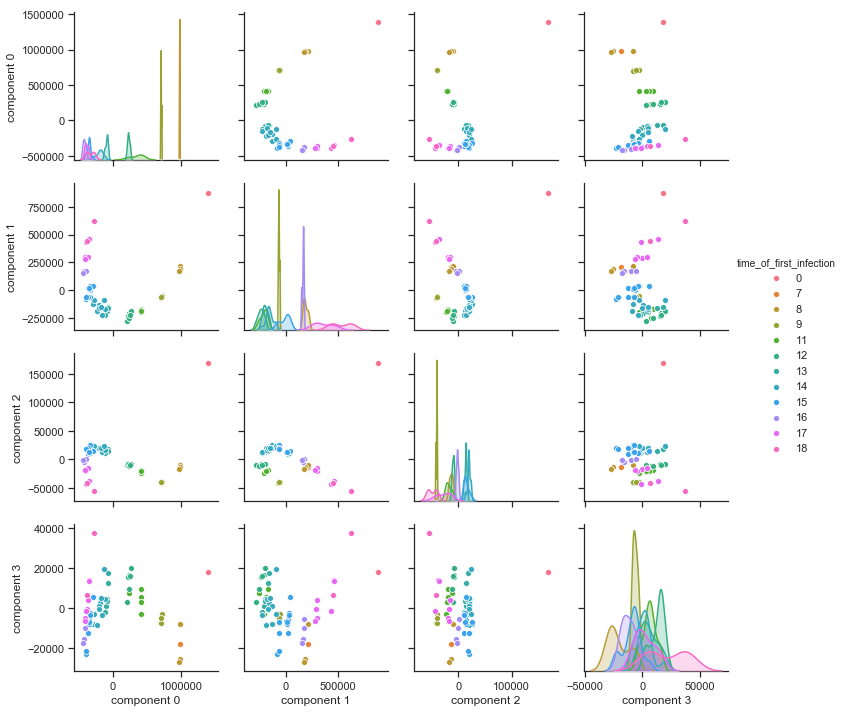

In [37]:
num_comp_to_show = 4
df = pd.DataFrame(pca_transformed_input)
df.columns = ["component {:d}".format(i) for i in range(len(pca_transformed_input.T))]
df['time_of_first_infection'] = time_of_first_infection
g = sns.pairplot(df, vars=["component {:d}".format(d) for d in range(num_comp_to_show)], hue='time_of_first_infection')

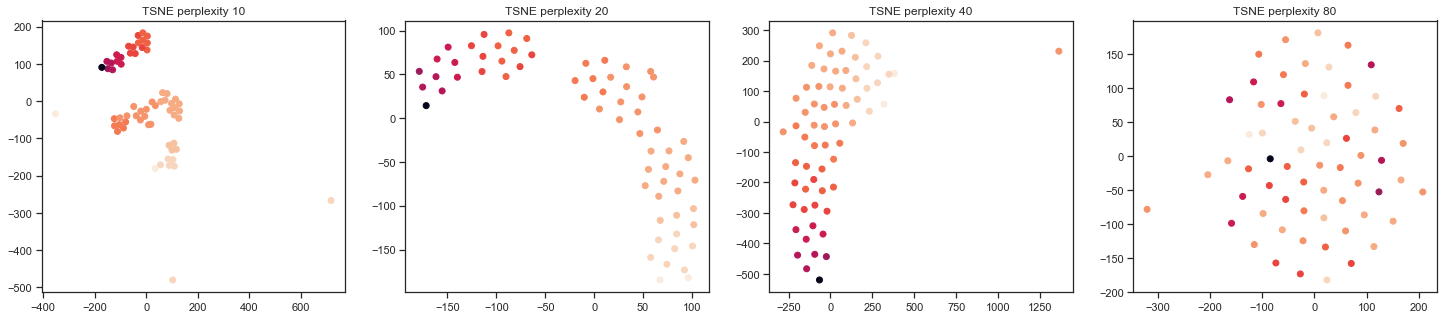

In [39]:
fig,axes = plt.subplots(1,4, figsize=(25,5))

for p,ax in zip([10,20,40,80], axes.ravel()):
    node_position_model = TSNE(n_components=2, init='random', perplexity=p)
    embedding = node_position_model.fit_transform(pair_dot)

    ax.scatter(embedding[:,0], embedding[:,1], c=df['time_of_first_infection'])
    ax.set_title("TSNE perplexity {:d}".format(p))

In [32]:
neighbor_params = {'algorithm': 'ball_tree'}

mydmap = dm.DiffusionMap.from_sklearn(n_evecs=2, k=400, epsilon=50., alpha=10., neighbor_params=neighbor_params)
# fit to data and return the diffusion map.
dmap = mydmap.fit_transform(pair_dot)

/Users/duaneloh/anaconda3/envs/idp/lib/python3.6/site-packages/pydiffmap/diffusion_map.py:159: RuntimeWarning: divide by zero encountered in true_divide
  dmap = np.dot(evecs, np.diag(np.sqrt(-1. / evals)))
/Users/duaneloh/anaconda3/envs/idp/lib/python3.6/site-packages/pydiffmap/diffusion_map.py:159: RuntimeWarning: invalid value encountered in sqrt
  dmap = np.dot(evecs, np.diag(np.sqrt(-1. / evals)))


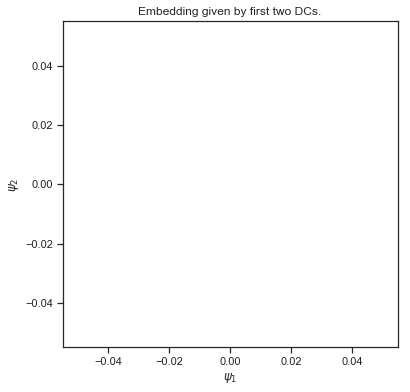

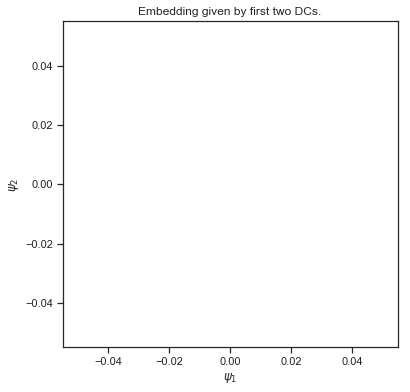

In [33]:
from pydiffmap.visualization import embedding_plot, data_plot

embedding_plot(mydmap, scatter_kwargs = {'c': dmap[:,0], 'cmap': 'Spectral'})
#data_plot(mydmap, dim=3, scatter_kwargs = {'cmap': 'Spectral'})